In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
iPadTrain = pd.read_csv('./data/eBayiPadTrain.csv', index_col='UniqueID')
iPadTest = pd.read_csv('./data/eBayiPadTest.csv', index_col='UniqueID')

In [3]:
iPadTrain.head()

,description,biddable,startprice,condition,cellular,carrier,color,storage,productline,sold
UniqueID,,,,,,,,,,
10001,iPad is in 8.5+ out of 10 cosmetic condition!,0,159.99,Used,0,None,Black,16,iPad 2,0
10002,"Previously used, please read description. May ...",1,0.99,Used,1,Verizon,Unknown,16,iPad 2,1
10003,NaN,0,199.99,Used,0,None,White,16,iPad 4,1
10004,NaN,0,235.00,New other (see details),0,None,Unknown,16,iPad mini 2,0
10005,Please feel free to buy. All products have bee...,0,199.99,Seller refurbished,Unknown,Unknown,Unknown,Unknown,Unknown,0


### Relationship between starting price and the fact whether iPad got sold or not ?

In [4]:
sold_iPads = iPadTrain.groupby('sold')

In [5]:
sold_iPads.startprice.mean()

sold
0    283.119650
1    127.437116
Name: startprice, dtype: float64

<b>Indeed iPads that were listed successfully had lower average starting price.</b>

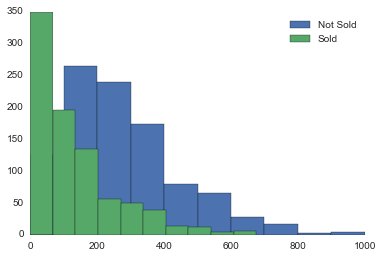

In [6]:
plt.hist(sold_iPads.get_group(0).startprice.values, label='Not Sold')
plt.hist(sold_iPads.get_group(1).startprice.values, label='Sold')
plt.legend(loc='best');

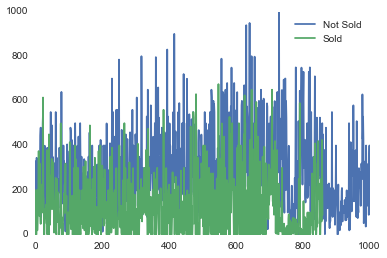

In [7]:
plt.plot(sold_iPads.get_group(0).startprice.values, label='Not Sold')
plt.plot(sold_iPads.get_group(1).startprice.values, label='Sold')
plt.legend(loc='best');

## Lets see class size distribution for two classes ( Sold - 1, Not Sold - 0 )

In [8]:
iPadTrain.sold.value_counts()

0    1001
1     860
dtype: int64

<b>So there are a bit more iPads that were not listed successfully.</b>

### Lets take a look whether storage has any effect on sales of these iPads

In [9]:
iPadTrain.storage.unique()

array(['16', 'Unknown', '32', '64', '128'], dtype=object)

<b>16GB, 32GB, 64GB, and 128GB iPads were put on sale.</b>

In [10]:
sold_iPads.get_group(0).groupby('storage').size().order()

storage
128         68
Unknown    110
64         167
32         183
16         473
dtype: int64

In [11]:
sold_iPads.get_group(1).groupby('storage').size().order()

storage
128         22
Unknown     73
64         147
32         157
16         461
dtype: int64

<b>People tend not to buy iPads with 128GB memory storage.</b>

## Relationship between biddable and sold

In [12]:
iPadTrain.groupby(['biddable', 'sold']).size()

biddable  sold
0         0       804
          1       220
1         0       197
          1       640
dtype: int64

<b>Looks like iPads on which bidding was enabled were listed successfully.</b>

In [13]:
iPadTrain.groupby(['cellular', 'sold']).size()

cellular  sold
0         0       562
          1       545
1         0       296
          1       224
Unknown   0       143
          1        91
dtype: int64

<b>Whether an iPad has cellular service or not does not affect its sales.</b>

### Relationship between condition and sold

In [92]:
iPadTrain.groupby(['condition', 'sold']).size()

condition                 sold
For parts or not working  0        75
                          1       106
Manufacturer refurbished  0        25
                          1        14
New                       0       204
                          1        85
New other (see details)   0        51
                          1        34
Seller refurbished        0        74
                          1        35
Used                      0       572
                          1       586
dtype: int64

In [93]:
iPadTrain[iPadTrain.condition == 'Manufacturer refurbished'].startprice.describe()

count     39.000000
mean     275.079231
std      172.556251
min        0.990000
25%      204.920000
50%      249.990000
75%      319.975000
max      795.990000
Name: startprice, dtype: float64

In [94]:
iPadTrain[iPadTrain.condition == 'Seller refurbished'].startprice.describe()

count    109.000000
mean     194.932936
std      137.038976
min        0.010000
25%       99.990000
50%      199.990000
75%      259.990000
max      679.950000
Name: startprice, dtype: float64

In [95]:
iPadTrain[iPadTrain.condition == 'Used'].startprice.describe()

count    1158.000000
mean      180.070259
std       137.035686
min         0.010000
25%        80.000000
50%       159.970000
75%       250.000000
max       999.000000
Name: startprice, dtype: float64

## Re-label condition variable

In [96]:
from sklearn.preprocessing import LabelEncoder

In [97]:
iPadTrain.condition.unique()

array(['Used', 'New other (see details)', 'Seller refurbished', 'New',
       'Manufacturer refurbished', 'For parts or not working'], dtype=object)

In [98]:
iPadTest.condition.unique()

array(['Used', 'Manufacturer refurbished', 'New other (see details)',
       'Seller refurbished', 'New', 'For parts or not working'], dtype=object)

In [99]:
lbl = LabelEncoder().fit(iPadTrain.condition)
iPadTrain.condition = lbl.transform(iPadTrain.condition)
iPadTest.condition = lbl.transform(iPadTest.condition)

### Check to see whether a product with description is listed successfully

In [157]:
import math

In [168]:
def check_description(desc):
    if type(desc) == float:
        return int(not math.isnan(desc))
    else:
        return 1
iPadTrain['has_description'] = iPadTrain.description.map(check_description)

In [169]:
iPadTrain.groupby(['has_description', 'sold']).size()

has_description  sold
0                0       555
                 1       516
1                0       446
                 1       344
dtype: int64

## Simple logistic regression model

In [170]:
X = iPadTrain[iPadTrain.columns.drop('sold')]
y = iPadTrain.sold

In [171]:
from sklearn.cross_validation import train_test_split

In [172]:
Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.3, random_state=0)

In [173]:
from sklearn.linear_model import LogisticRegression

In [174]:
features = ['startprice', 'biddable', 'condition', 'has_description']
features_train = Xt[features]
features_test = Xv[features]

In [175]:
est = LogisticRegression(C=10.).fit(features_train, yt)

In [176]:
est

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [177]:
from sklearn.metrics import roc_auc_score

In [178]:
yt_pred = est.predict(features_train)

In [179]:
print 'Training score ', roc_auc_score(yt, yt_pred)

Training score  0.772974219062


In [180]:
yv_pred = est.predict(features_test)

In [181]:
print 'Test score ', roc_auc_score(yv, yv_pred)

Test score  0.787763225475
